In [168]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
from scipy.spatial import distance
from scripts.vectology_functions import create_aaa_distances, embed_text

Set up some things

In [169]:
os.makedirs('output', exist_ok=True)

Get some variable data

In [181]:
# phewas 

def get_phewas(variant='rs123',pval=1e-3):
    gwas_api_url = "http://gwasapi.mrcieu.ac.uk/phewas"
    payload = {"variant": variant, "pval": pval}
    response = requests.post(gwas_api_url, json=payload)
    res = response.json()
    print(len(res))
    df = pd.json_normalize(res)
    print(df.head())
    return df

trait_df = get_phewas(variant='rs1333049',pval=1e-10)

77
       beta  position chr             p        se       n           id  \
0  0.004800  22125503   9  2.099910e-39  0.000366  461880   ukb-b-8468   
1  0.002296  22125503   9  2.399940e-37  0.000180  462933  ukb-b-12465   
2  0.001550  22125503   9  1.000000e-14  0.000200  444235   ukb-b-6951   
3  0.002281  22125503   9  2.800270e-27  0.000211  462933   ukb-b-7869   
4  0.001116  22125503   9  1.599930e-11  0.000166  462933  ukb-b-19698   

        rsid ea nea       eaf  \
0  rs1333049  C   G  0.483367   
1  rs1333049  C   G  0.483358   
2  rs1333049  C   G  0.483395   
3  rs1333049  C   G  0.483358   
4  rs1333049  C   G  0.483358   

                                               trait  
0  Vascular/heart problems diagnosed by doctor: A...  
1  Operation code: coronary artery bypass grafts ...  
2  Treatment speciality of consultant (recoded): ...  
3  Operation code: coronary angioplasty (ptca) +/...  
4             Treatment/medication code: clopidogrel  


In [182]:
# preprocess the text  

process_text=[]
for k,g in trait_df.groupby(np.arange(len(trait_df))//20):
    params={'text_list':list(g['trait'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
trait_df.loc[:, 'processed'] = process_text
print(trait_df.head())

77
       beta  position chr             p        se       n           id  \
0  0.004800  22125503   9  2.099910e-39  0.000366  461880   ukb-b-8468   
1  0.002296  22125503   9  2.399940e-37  0.000180  462933  ukb-b-12465   
2  0.001550  22125503   9  1.000000e-14  0.000200  444235   ukb-b-6951   
3  0.002281  22125503   9  2.800270e-27  0.000211  462933   ukb-b-7869   
4  0.001116  22125503   9  1.599930e-11  0.000166  462933  ukb-b-19698   

        rsid ea nea       eaf  \
0  rs1333049  C   G  0.483367   
1  rs1333049  C   G  0.483358   
2  rs1333049  C   G  0.483395   
3  rs1333049  C   G  0.483358   
4  rs1333049  C   G  0.483358   

                                               trait  \
0  Vascular/heart problems diagnosed by doctor: A...   
1  Operation code: coronary artery bypass grafts ...   
2  Treatment speciality of consultant (recoded): ...   
3  Operation code: coronary angioplasty (ptca) +/...   
4             Treatment/medication code: clopidogrel   

                

Create vectors for each variable

In [183]:
def encode_traits(trait_df):

    vectorList=[]

    #loop through 10 rows at a time
    for k,g in trait_df.groupby(np.arange(len(trait_df))//10):
        #get processed text
        textList=list(g['processed'])
        # embed using BioSentVec initially
        res = embed_text(textList,'BioSentVec')
        
        #add vectors to list
        for i in range(0,len(textList)):
            #ignore empty vectors
            if np.count_nonzero(res[i])>0:
                vectorList.append(res[i])
            else:
                #print('No BioSentVec',textList[i])
                #res2 = embed_text([textList[i]],'biobert_v1.1_pubmed')
                vectorList.append(res[i])

    print(len(vectorList),'vectors created')        
    trait_df['vector'] = vectorList
    return trait_df

trait_df = encode_traits(trait_df)
print(trait_df.head())
#print(trait_df['vector'])

77 vectors created
       beta  position chr             p        se       n           id  \
0  0.004800  22125503   9  2.099910e-39  0.000366  461880   ukb-b-8468   
1  0.002296  22125503   9  2.399940e-37  0.000180  462933  ukb-b-12465   
2  0.001550  22125503   9  1.000000e-14  0.000200  444235   ukb-b-6951   
3  0.002281  22125503   9  2.800270e-27  0.000211  462933   ukb-b-7869   
4  0.001116  22125503   9  1.599930e-11  0.000166  462933  ukb-b-19698   

        rsid ea nea       eaf  \
0  rs1333049  C   G  0.483367   
1  rs1333049  C   G  0.483358   
2  rs1333049  C   G  0.483395   
3  rs1333049  C   G  0.483358   
4  rs1333049  C   G  0.483358   

                                               trait  \
0  Vascular/heart problems diagnosed by doctor: A...   
1  Operation code: coronary artery bypass grafts ...   
2  Treatment speciality of consultant (recoded): ...   
3  Operation code: coronary angioplasty (ptca) +/...   
4             Treatment/medication code: clopidogrel   



Compare all against all using cosine

In [184]:
# create 2d matrix of vectors
vector_2d = list(trait_df['vector'])
#print(vector_2d)
data = np.array(vector_2d)
print(data.shape)

# do all against all cosine
vector_matrix = create_aaa_distances(vector_2d)

(77, 700)
Creating distances...
77
2926


In [185]:
# create term-score-term triples
def create_triples(vector_matrix, term_list):
    d = []
    mCount=0
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                #print(ids[i],ids[j],1-pws[mCount])
                score = 1-vector_matrix[mCount]
                d.append({'source':term_list[i],'score':score,'target':term_list[j]})
                mCount+=1
    df = pd.DataFrame(d)
    print(df.head())
    return df

create_triples(vector_matrix,trait_df['processed'])

                                              source     score  \
0  vascular/heart problems diagnosed by doctor: a...  0.296591   
1  vascular/heart problems diagnosed by doctor: a...  0.329873   
2  vascular/heart problems diagnosed by doctor: a...  0.341530   
3  vascular/heart problems diagnosed by doctor: a...  0.158906   
4  vascular/heart problems diagnosed by doctor: a...  0.354530   

                                              target  
0               coronary artery bypass grafts (cabg)  
1  treatment speciality of consultant (recoded): ...  
2              coronary angioplasty (ptca) +/- stent  
3                                        clopidogrel  
4                 illnesses of mother: heart disease  


,source,score,target
0,vascular/heart problems diagnosed by doctor: a...,0.296591,coronary artery bypass grafts (cabg)
1,vascular/heart problems diagnosed by doctor: a...,0.329873,treatment speciality of consultant (recoded): ...
2,vascular/heart problems diagnosed by doctor: a...,0.341530,coronary angioplasty (ptca) +/- stent
3,vascular/heart problems diagnosed by doctor: a...,0.158906,clopidogrel
4,vascular/heart problems diagnosed by doctor: a...,0.354530,illnesses of mother: heart disease
...,...,...,...
2921,illnesses of mother: heart disease,0.342403,heart attack/myocardial infarction
2922,illnesses of mother: heart disease,0.325396,father's age at death
2923,vascular/heart problems diagnosed by doctor: a...,0.260861,heart attack/myocardial infarction
2924,vascular/heart problems diagnosed by doctor: a...,0.190505,father's age at death


Visualise

In [189]:
def plot_compare(dis,name,term_list):
    text_max = 50
    dis_dic={}
    mCount=0
    for i in range(0,len(term_list)):
        dis_dic[term_list[i][:text_max]]={}
    for i in range(0,len(term_list)):
        for j in range(i,len(term_list)):
            if i != j:
                score = 1-dis[mCount]
                mCount+=1
                dis_dic[term_list[i][:text_max]][term_list[j][:text_max]]=score
                dis_dic[term_list[j][:text_max]][term_list[i][:text_max]]=score
    df = pd.DataFrame(dis_dic)
    #sort the rows and columns to be in same order and replace diagonal
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    #print(df.head())
    #replace NaN with 1 to create perfect maps on the diagonal
    df = df.fillna(1)
    
    sns_plot = sns.clustermap(
        df,
        cmap='coolwarm',
    )
    #sns_plot.ax_heatmap.set_title(name)
    sns_plot.savefig(f"output/{name}.pdf",dpi=1000)
    return df


,acute myocardial infarction,anastomosis of mammary artery to left anterior des,angina,angina pectoris,"angina pectoris,",angiocardiography of left side of heart,apoliprotein b,aspirin,atherosclerotic heart disease,atorvastatin,...,percutaneous transluminal balloon angioplasty and,presence of aortocoronary bypass graft,presence of coronary angioplasty implant and graft,pure hypercholesterolaemia,saphenous vein graft replacement of two coronary a,simvastatin,treatment speciality of consultant (recoded): card,unstable angina,vascular/heart problems diagnosed by doctor: angin,vascular/heart problems diagnosed by doctor: heart
acute myocardial infarction,1.000000,0.353980,0.434368,0.511219,0.511219,0.253929,0.089318,0.232470,0.445390,0.215823,...,0.439699,0.344021,0.365795,0.276509,0.359442,0.192497,0.184270,0.552738,0.353789,0.334127
anastomosis of mammary artery to left anterior des,0.353980,1.000000,0.244278,0.313289,0.313289,0.351742,0.043647,0.158095,0.308266,0.186588,...,0.507927,0.350569,0.356347,0.183078,0.586243,0.140923,0.216857,0.281136,0.261246,0.217305
angina,0.434368,0.244278,1.000000,0.821654,0.821654,0.161066,0.019437,0.229619,0.320505,0.207736,...,0.328093,0.234180,0.238805,0.204613,0.211066,0.135745,0.122896,0.778005,0.579614,0.203208
angina pectoris,0.511219,0.313289,0.821654,1.000000,1.000000,0.247198,0.041196,0.213706,0.396692,0.223728,...,0.327842,0.287478,0.256256,0.305256,0.274923,0.169620,0.149636,0.692042,0.534665,0.263222
"angina pectoris,",0.511219,0.313289,0.821654,1.000000,1.000000,0.247198,0.041196,0.213706,0.396692,0.223728,...,0.327842,0.287478,0.256256,0.305256,0.274923,0.169620,0.149636,0.692042,0.534665,0.263222
angiocardiography of left side of heart,0.253929,0.351742,0.161066,0.247198,0.247198,1.000000,0.049643,0.174430,0.336596,0.137447,...,0.299082,0.240727,0.240522,0.138676,0.337466,0.136893,0.209376,0.172011,0.246686,0.350662
apoliprotein b,0.089318,0.043647,0.019437,0.041196,0.041196,0.049643,1.000000,0.074713,0.084149,0.057946,...,0.113291,0.069692,0.129050,0.096315,0.097063,0.108180,0.078541,0.066590,0.052699,0.057699
aspirin,0.232470,0.158095,0.229619,0.213706,0.213706,0.174430,0.074713,1.000000,0.117458,0.377617,...,0.294218,0.183973,0.213136,0.163547,0.213880,0.331555,0.147196,0.268713,0.235726,0.235641
atherosclerotic heart disease,0.445390,0.308266,0.320505,0.396692,0.396692,0.336596,0.084149,0.117458,1.000000,0.244702,...,0.353158,0.303861,0.240365,0.329696,0.373560,0.179989,0.154779,0.395875,0.215355,0.239081
atorvastatin,0.215823,0.186588,0.207736,0.223728,0.223728,0.137447,0.057946,0.377617,0.244702,1.000000,...,0.274313,0.124958,0.201403,0.277978,0.228377,0.740081,0.075777,0.294346,0.167349,0.159253


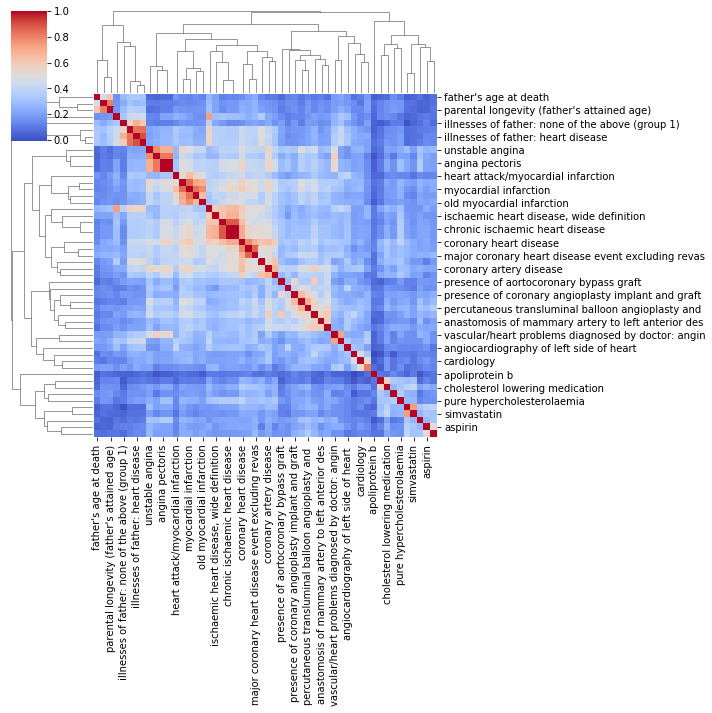

In [190]:
plot_compare(vector_matrix,'test',trait_df['processed'])